# Análise de Componente Principal (PCA): Dados de Carga da ANTAQ no ano de 2018

## Setup

In [100]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import glob

In [101]:
ano_amostra = 2018

In [102]:
dict_types = pd.read_pickle("datasets/aux_carga_dtypes.pkl").to_dict()

### Funções úteis

In [103]:
def criar_mestre(percentual: int):
    # Importações
    step = max(int(100/percentual), 1)
    df_carga = pd.read_csv(f"datasets/{ano_amostra}Carga.csv", sep=";", dtype=dict_types, decimal=",")
    df_carga_cont = pd.read_csv(f"datasets/{ano_amostra}Carga_Conteinerizada.csv", sep=";", dtype=dict_types, decimal=",")
    print("Importações feitas!")

    # Amostragem do dataset
    df_carga = df_carga[::step]
    
    # Junção dos datasets
    df_mestre = pd.merge(df_carga, df_carga_cont, on="IDCarga", how="left")
    print("Datasets juntados!")

    # Transformação de CDMercadoria e CDMercadoriaConteinerizada
    df_mestre["CDMercadoria"] = df_mestre["CDMercadoriaConteinerizada"].combine_first(df_mestre["CDMercadoria"])
    df_mestre["VLPesoCargaBruta"] = df_mestre["VLPesoCargaConteinerizada"].combine_first(df_mestre["VLPesoCargaBruta"])
    print("Colunas combinadas!")

    # Drop das linhas inúteis
    df_mestre.drop(["IDCarga", "IDAtracacao", "CDMercadoriaConteinerizada", "VLPesoCargaConteinerizada"], axis=1, inplace=True)
    print("Colunas dropadas!")

    df_mestre.to_csv(f"datasets/{ano_amostra}Carga_Mestre.csv", index=False)
    print("Arquivo finalizado criado!")

    # Limpeza (forçar deleção)
    del df_carga
    del df_carga_cont
    del df_mestre

## Carga mestre

In [104]:
if not glob.glob(f"datasets/{ano_amostra}Carga_Mestre.csv"):
    criar_mestre(5)

print("Iniciando importação Dataset mestre!")
df_mestre = pd.read_csv(f"datasets/{ano_amostra}Carga_Mestre.csv", dtype=dict_types)
print("Dataframe Mestre importado!")
df_mestre.info()

Importações feitas!
Datasets juntados!
Colunas combinadas!
Colunas dropadas!
Arquivo finalizado criado!
Iniciando importação Dataset mestre!
Dataframe Mestre importado!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199202 entries, 0 to 199201
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   Origem                                  194303 non-null  category
 1   Destino                                 194303 non-null  category
 2   CDMercadoria                            199202 non-null  category
 3   Tipo Operação da Carga                  199202 non-null  category
 4   Carga Geral Acondicionamento            195745 non-null  category
 5   ConteinerEstado                         184135 non-null  category
 6   Tipo Navegação                          199202 non-null  category
 7   FlagAutorizacao                         199202 non-null  category
 8   FlagC

### Colunas

In [159]:
df_mestre.columns

Index(['Origem', 'Destino', 'CDMercadoria', 'Tipo Operação da Carga',
       'Carga Geral Acondicionamento', 'ConteinerEstado', 'Tipo Navegação',
       'FlagAutorizacao', 'FlagCabotagem', 'FlagCabotagemMovimentacao',
       'FlagConteinerTamanho', 'FlagLongoCurso', 'FlagMCOperacaoCarga',
       'FlagOffshore', 'FlagTransporteViaInterioir',
       'Percurso Transporte em vias Interiores',
       'Percurso Transporte Interiores', 'STNaturezaCarga', 'STSH2', 'STSH4',
       'Natureza da Carga', 'Sentido', 'TEU', 'QTCarga', 'VLPesoCargaBruta'],
      dtype='object')

### Temporário

In [105]:
# df_mestre.drop("Unnamed: 0", axis=1, inplace=True)

### Categorização

In [140]:
df_cat = pd.DataFrame()

In [141]:
for col in df_mestre.columns:
   type_col = df_mestre[col].dtype
   if type_col == "object" or type_col == "boolean":
       df_cat[col] = df_mestre[col].astype('category').cat.codes
   elif type_col == "category":
        df_cat[col] = df_mestre[col].cat.codes
   else:
        df_cat[col] = df_mestre[col] 

In [108]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199202 entries, 0 to 199201
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Origem                                  199202 non-null  int16  
 1   Destino                                 199202 non-null  int16  
 2   CDMercadoria                            199202 non-null  int16  
 3   Tipo Operação da Carga                  199202 non-null  int8   
 4   Carga Geral Acondicionamento            199202 non-null  int8   
 5   ConteinerEstado                         199202 non-null  int8   
 6   Tipo Navegação                          199202 non-null  int8   
 7   FlagAutorizacao                         199202 non-null  int8   
 8   FlagCabotagem                           199202 non-null  int8   
 9   FlagCabotagemMovimentacao               199202 non-null  int8   
 10  FlagConteinerTamanho                    1992

## Normalização

In [109]:
arr_mestre_norm = StandardScaler().fit_transform(df_cat)

## PCA

In [111]:
pca = PCA(n_components = 3)

In [112]:
df_mestre_pca = pca.fit_transform(arr_mestre_norm)

In [113]:
df_mestre_pca = pd.DataFrame(df_mestre_pca, columns=pca.get_feature_names_out())

In [114]:
pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [115]:
df_comp_pca = pd.DataFrame(pca.components_, pca.get_feature_names_out(), columns=df_mestre.columns)

In [116]:
del arr_mestre_norm

### PCA0

In [117]:
pca_rel = "pca0"

In [118]:
df_comp_pca.loc[pca_rel:pca_rel,df_comp_pca.loc[pca_rel].abs().sort_values(ascending=False).index]

,STSH4,STSH2,FlagConteinerTamanho,Carga Geral Acondicionamento,Natureza da Carga,Percurso Transporte em vias Interiores,STNaturezaCarga,ConteinerEstado,FlagLongoCurso,Tipo Navegação,...,FlagCabotagemMovimentacao,TEU,FlagCabotagem,Sentido,Destino,VLPesoCargaBruta,FlagAutorizacao,FlagMCOperacaoCarga,QTCarga,FlagOffshore
pca0,-0.417547,-0.415613,-0.301465,0.287904,0.280325,0.267223,-0.253467,-0.234928,-0.229961,-0.181257,...,0.094432,-0.086069,0.07842,0.04534,-0.044996,0.030134,0.027319,0.02479,-0.008003,0.007752


### PCA1

In [119]:
pca_rel = "pca1"

In [120]:
df_comp_pca.loc[pca_rel:pca_rel,df_comp_pca.loc[pca_rel].abs().sort_values(ascending=False).index]

,FlagCabotagemMovimentacao,Tipo Navegação,FlagLongoCurso,FlagCabotagem,Tipo Operação da Carga,Origem,CDMercadoria,STSH4,ConteinerEstado,STSH2,...,Natureza da Carga,Destino,Percurso Transporte em vias Interiores,FlagOffshore,TEU,FlagAutorizacao,FlagTransporteViaInterioir,QTCarga,VLPesoCargaBruta,FlagMCOperacaoCarga
pca1,-0.471625,0.441508,0.400597,-0.362832,0.261492,0.227938,0.164513,-0.158716,-0.1583,-0.157331,...,0.066424,0.04725,0.043536,-0.034459,0.027445,0.022943,0.0202,0.019407,-0.002123,-0.000124


### PCA2

In [121]:
pca_rel = "pca2"

In [122]:
df_comp_pca.loc[pca_rel:pca_rel,df_comp_pca.loc[pca_rel].abs().sort_values(ascending=False).index]

,FlagTransporteViaInterioir,Percurso Transporte Interiores,Sentido,Destino,Percurso Transporte em vias Interiores,Origem,CDMercadoria,STNaturezaCarga,FlagMCOperacaoCarga,FlagCabotagem,...,TEU,Tipo Operação da Carga,VLPesoCargaBruta,QTCarga,Carga Geral Acondicionamento,FlagCabotagemMovimentacao,FlagOffshore,ConteinerEstado,FlagLongoCurso,FlagAutorizacao
pca2,-0.503926,-0.492317,0.397817,0.339351,-0.189485,-0.176087,-0.175987,-0.159402,-0.143579,-0.136681,...,0.058219,-0.056778,0.04867,0.040603,0.038725,-0.023513,0.008089,0.006923,-0.002227,0.000356


## Plotagem

### Plotagem vanila

In [ ]:
# %matplotlib widget
%matplotlib inline

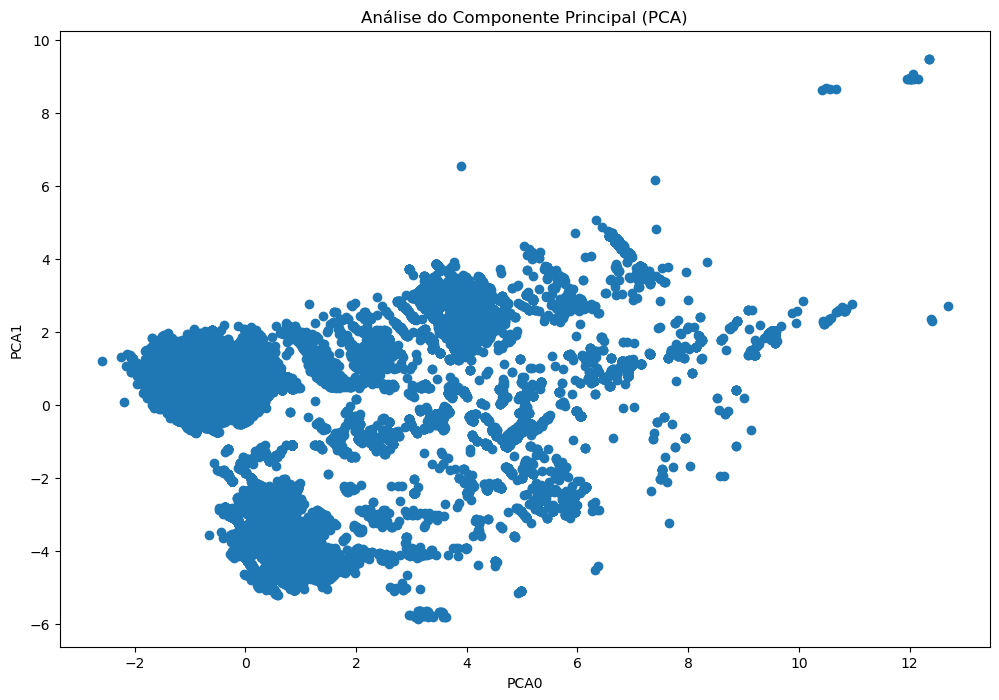

In [128]:
fig = plt.figure(figsize=(12, 8))
plt.title("Análise do Componente Principal (PCA)")
# ax = fig.add_subplot(projection="3d")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
# ax.set_zlabel("PCA2")
plt.scatter(df_mestre_pca["pca0"], df_mestre_pca["pca1"])
# ax.view_init(azim=15, elev=40)
plt.show()

### Por Natureza de Carga

In [130]:
x_col = "Natureza da Carga"

In [131]:
df_mestre[x_col].unique().tolist()

['Granel Sólido',
 'Granel Líquido e Gasoso',
 'Carga Conteinerizada',
 'Carga Geral']

In [132]:
x_estilos = {
    'Granel Sólido': ('#1f77b4', 'o'),
    'Carga Conteinerizada': ('#ff7f0e', 's'),
    'Carga Geral': ('#2ca02c', 'v'),
    'Granel Líquido e Gasoso': ('#d62728', '^')
}

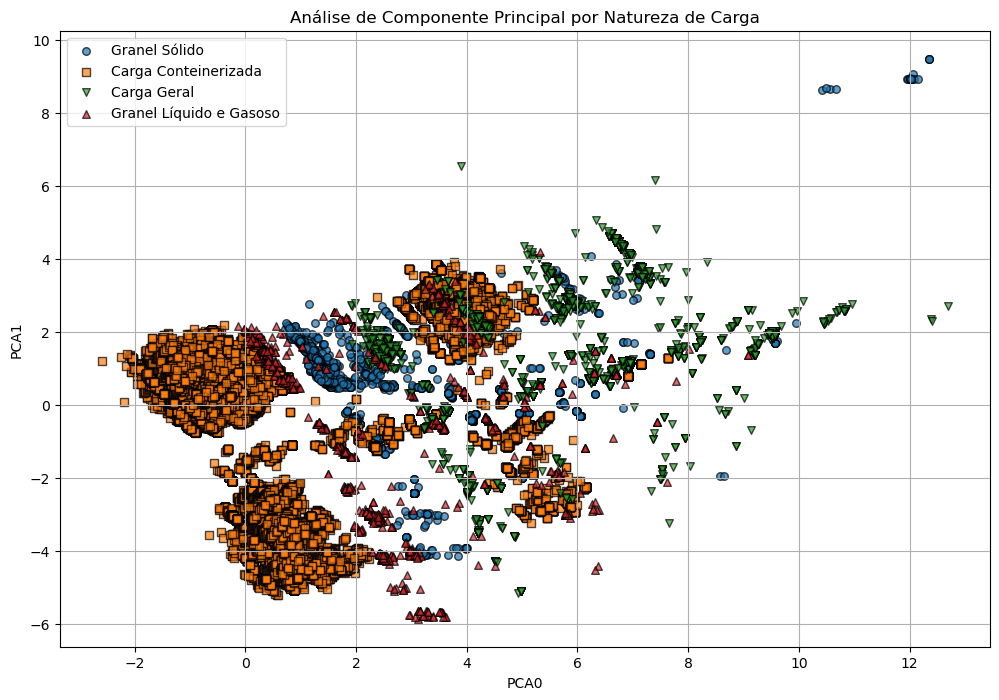

In [137]:
fig = plt.figure(figsize=(12, 8))
plt.title("Análise de Componente Principal por Natureza de Carga")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
# ax = fig.add_subplot(projection="3d")
# ax.set_zlabel("PCA2")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_mestre_pca[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

### Por Sentido

In [146]:
x_col = "Sentido"

In [147]:
df_mestre[x_col].unique().tolist()

['Embarcados', 'Desembarcados', 'Não Informado']

In [149]:
x_estilos = {
    'Embarcados': ('#1f77b4', 'o'),
    'Desembarcados': ('#ff7f0e', 's'),
    'Não Informado': ('#2ca02c', 'v')
}

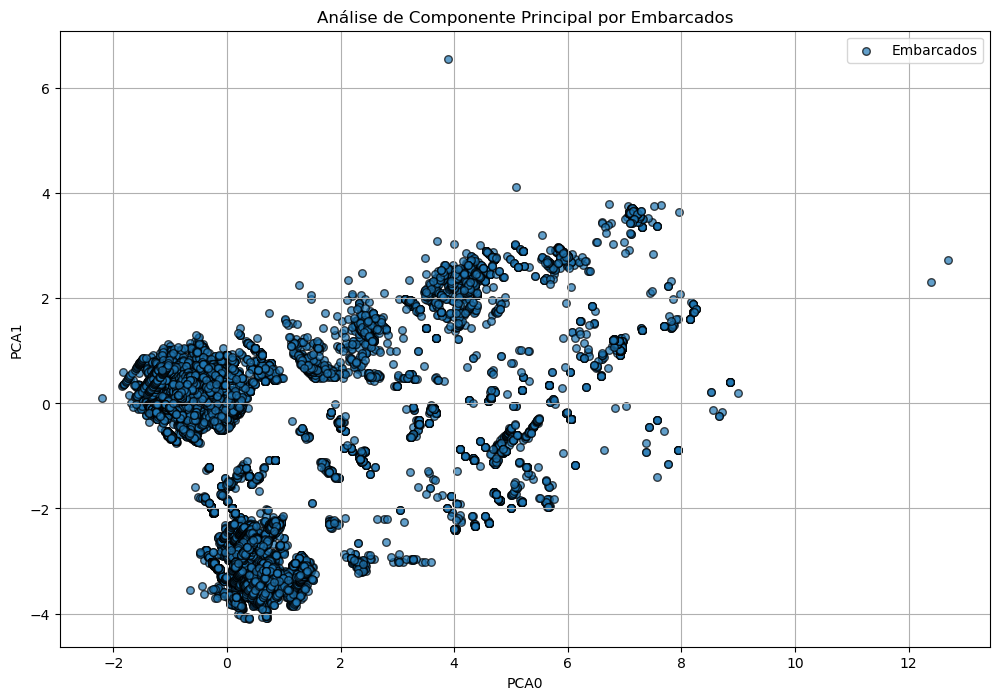

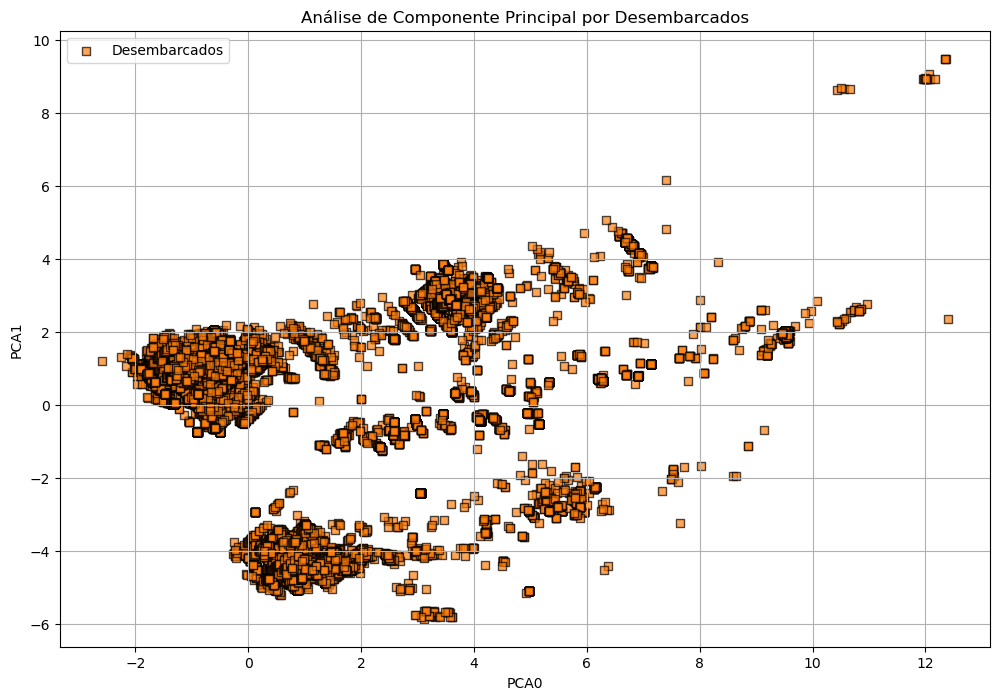

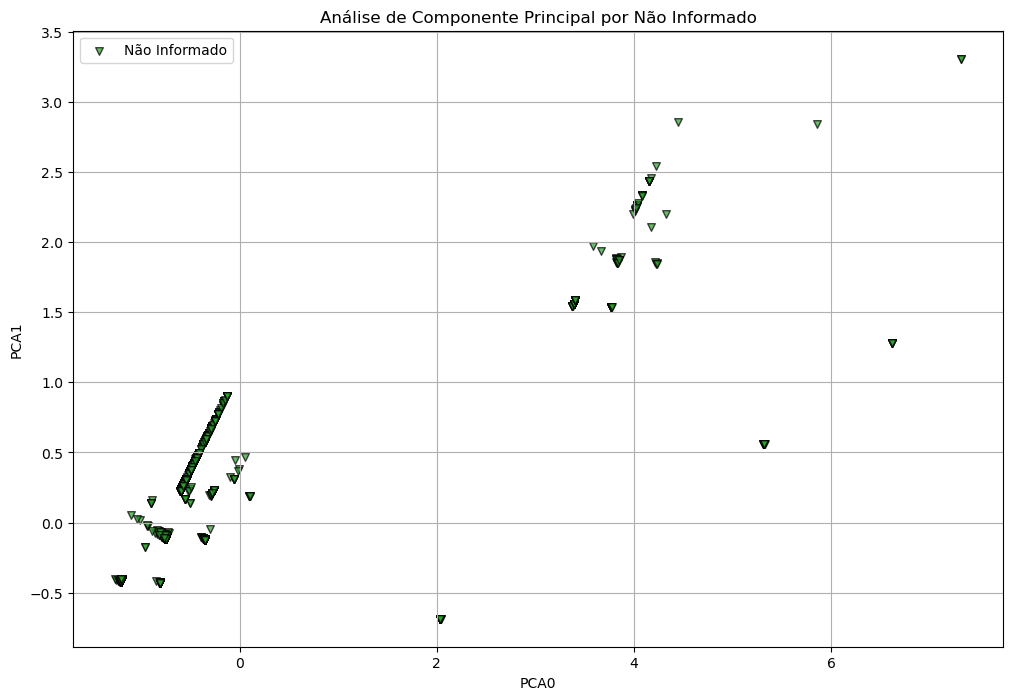

In [152]:
for x_, (cor, marker) in x_estilos.items():
    fig = plt.figure(figsize=(12, 8))
    plt.title(f"Análise de Componente Principal por {x_}")
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    # ax = fig.add_subplot(projection="3d")
    # ax.set_zlabel("PCA2")
    plt.grid(True)

    # Plotar os dados
    subset = df_mestre_pca[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

    plt.legend()
    plt.show()

Conclusão: Configuração parecida

### Por Tipo de Navegação

In [153]:
x_col = "Tipo Navegação"

In [154]:
df_mestre[x_col].unique().tolist()

['Apoio Marítimo',
 'Cabotagem',
 'Interior',
 'Longo Curso',
 'Apoio Portuário',
 'Não Indentificado']

In [155]:
x_estilos = {
    'Apoio Marítimo': ('#1f77b4', 'o'),
    'Cabotagem': ('#ff7f0e', 's'),
    'Interior': ('#2ca02c', 'v'),
    'Longo Curso': ('#d62728', '^'),
    'Apoio Portuário': ('#9467bd', 'D'),
    'Não Indentificado': ('#8c564b', 'P')
}

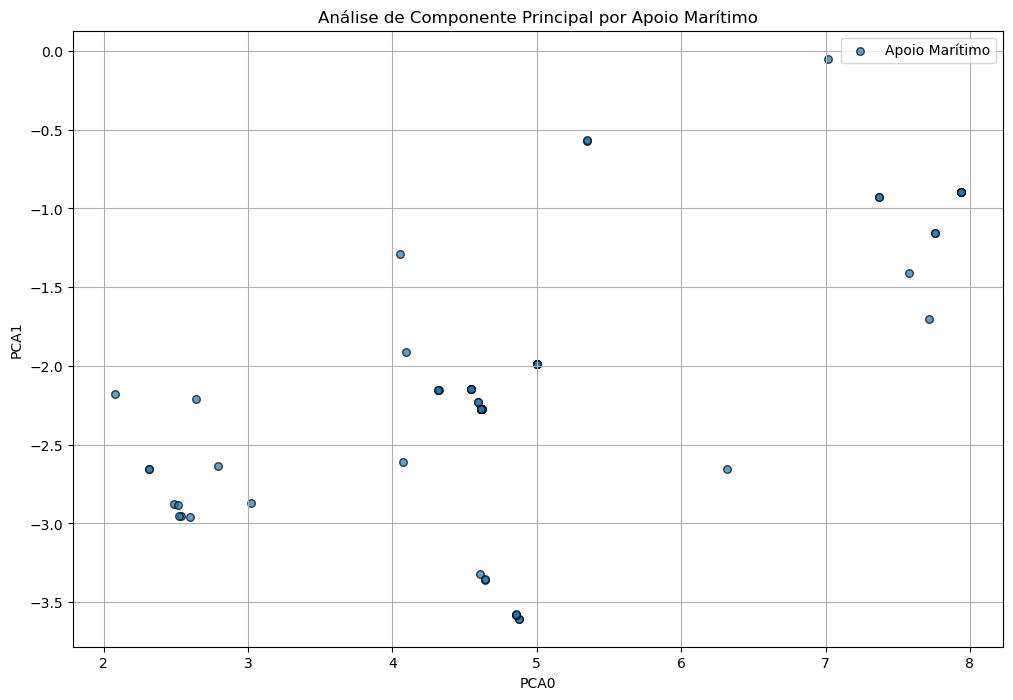

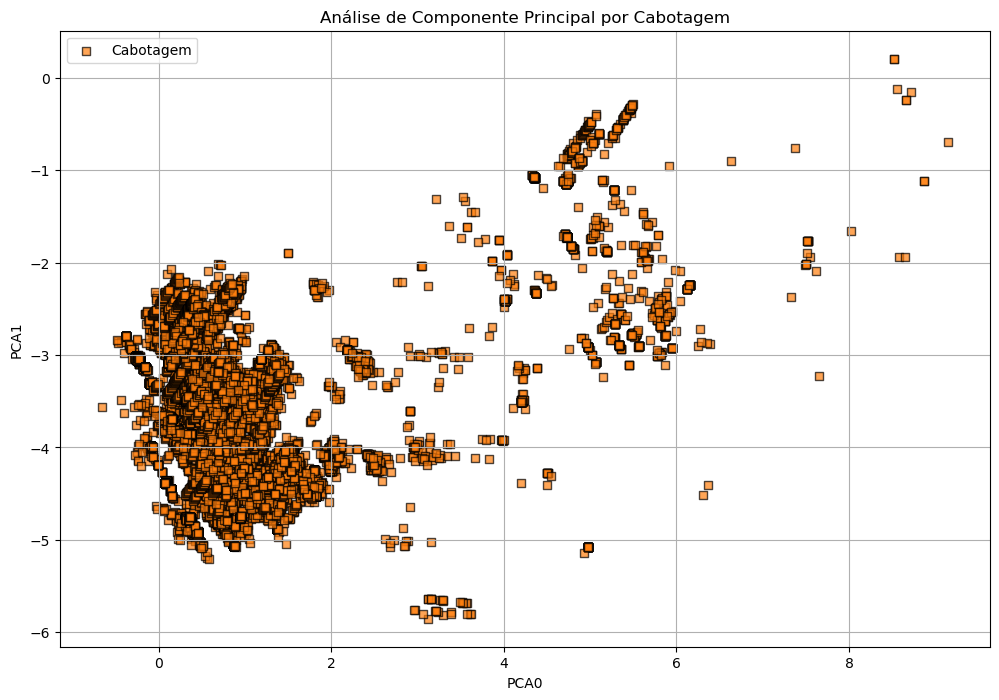

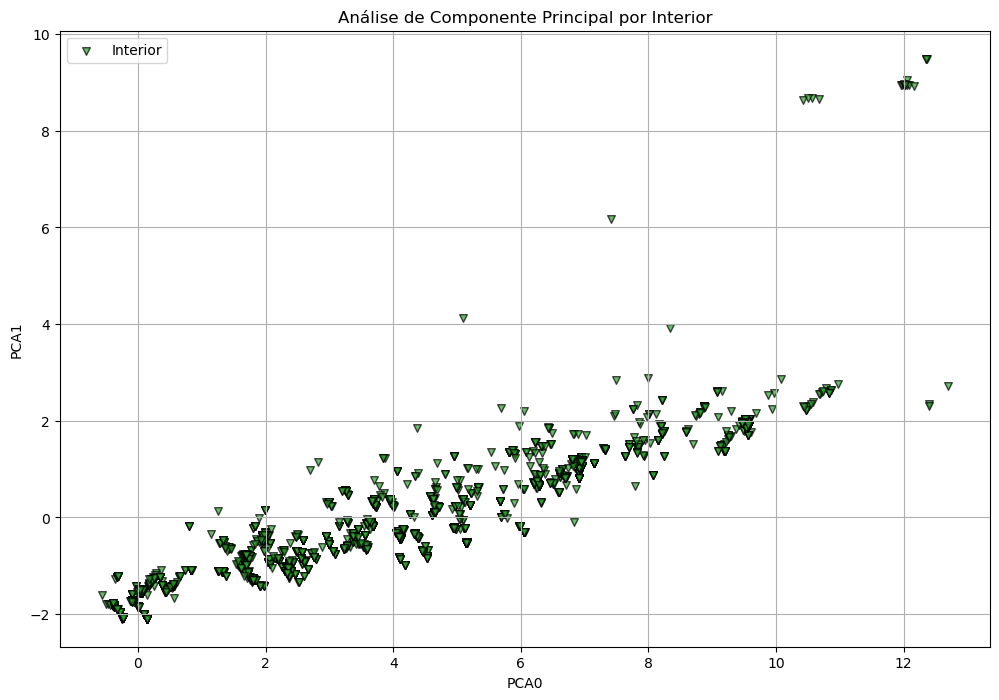

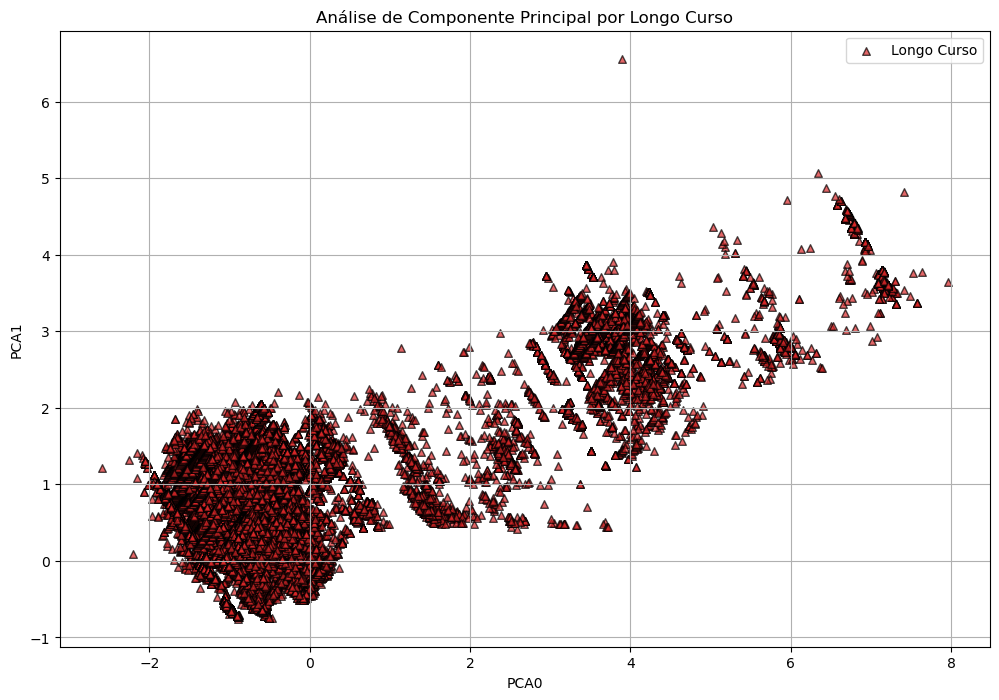

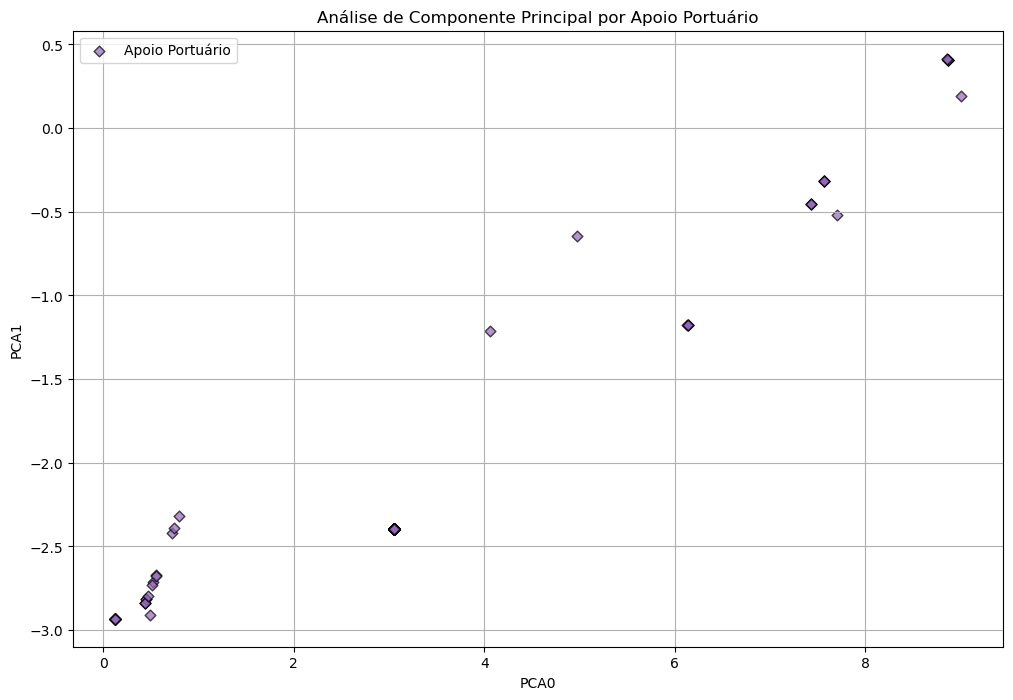

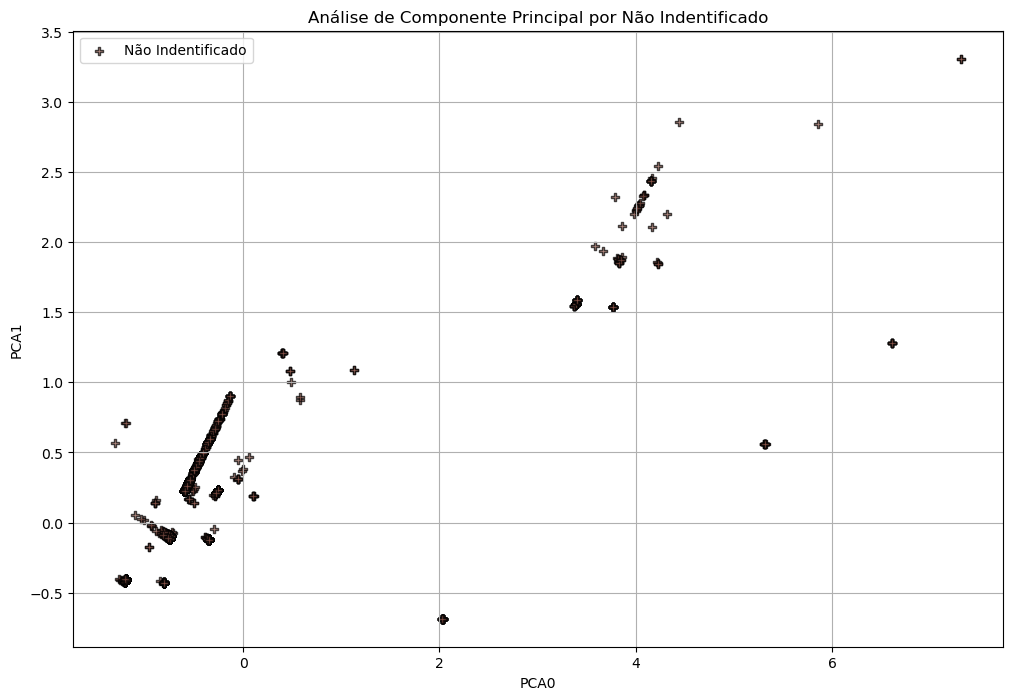

In [157]:
for x_, (cor, marker) in x_estilos.items():

    fig = plt.figure(figsize=(12, 8))
    plt.title(f"Análise de Componente Principal por {x_}")
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.grid(True)

    # Plotar os dados
    subset = df_mestre_pca[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

    plt.legend()
    plt.show()

## Por `FlagCabotagemMovimentacao`

In [177]:
x_col = "FlagCabotagem"

In [178]:
df_mestre[x_col].unique().tolist()

[False, True, <NA>]

In [179]:
x_estilos = {
    False: ('#1f77b4', 'o'),
    True: ('#ff7f0e', 's'),
    pd.NA: ('#2ca02c', 'v')
}

pandas._libs.missing.NAType

TypeError: boolean value of NA is ambiguous

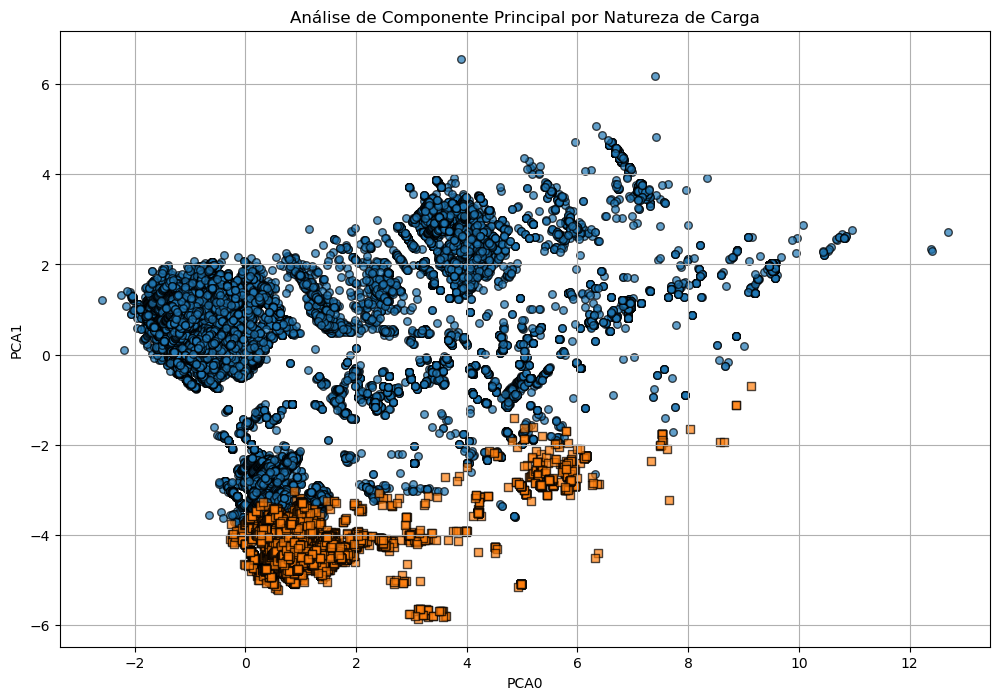

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.title("Análise de Componente Principal por Natureza de Carga")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
# ax = fig.add_subplot(projection="3d")
# ax.set_zlabel("PCA2")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_mestre_pca[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

NA não está sendo plotado?

### Por região geográfica na origem e Destino